In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from matplotlib.colors import SymLogNorm, Normalize

In [2]:
def hist_stats(hist_mid, hist_val):
    lowsum = highsum = 0.
    ilow = 0
    ihigh = len(hist_val) - 1
    sum_total = 0.
    sum_count = 0.
    std = 0.
    for val, count in zip(hist_mid, hist_val):
        if lowsum < highsum:
            lowsum += hist_val[ilow]
            ilow += 1
        else:
            highsum += hist_val[ihigh]
            ihigh -= 1
        sum_total += val * count
        sum_count += count
        std += count * val * val
        
    i = np.max([hist_val[ilow], hist_val[ihigh]])
    median = hist_mid[ihigh] + 0.5 + (highsum - lowsum) / (2 * i)
    mean = sum_total / sum_count
    std = np.sqrt(std / sum_count - mean ** 2)    
    return median, mean, std

In [3]:
class BackgroundHistogram(object):
    
    def __compute_binning(self, ndata, nsigma, minpixel):
        nbins = (ndata * np.sqrt(2/np.pi) * nsigma / minpixel) + 1
        return np.min([nbins, 4096]).astype(np.int)
    
    def __init__(self, mean, sigma, ndata, nsigma=5, minpixel=4):
        """
        Constructor
        """
        self.mean = mean
        self.sigma = sigma
        self.nbins = self.__compute_binning(ndata, nsigma, minpixel)
        self.bin_scale = 2 * (nsigma * sigma) / self.nbins
        self.bin_zero = mean - (nsigma * sigma)
        self.bin_const = 0.499999 - self.bin_zero / self.bin_scale
        self.bin_counts = np.zeros(self.nbins)
        
    def add(self, v):
        idx = (v / self.bin_scale + self.bin_const).astype(np.int)
        inrange = np.logical_and(0 <= idx, idx < self.nbins)
        for i in idx[inrange]:
            self.bin_counts[i] += 1
            
    def get_backguess(self, niter=100, rtol=1e-4):
        sigma = 10
        prev_sigma = 1.
        counts = self.bin_counts
        values = np.arange(len(self.bin_counts))

        while niter > 0 and sigma >= 0.1 and abs(sigma / prev_sigma - 1) > rtol:
            prev_sigma = sigma
            median, mean, sigma = hist_stats(values, counts)
            idx = np.logical_and(values >= int(median - sigma * 3 + 0.5), values <= int(median + sigma * 3 + 0.5))
            values = values[idx]
            counts = counts[idx]
            niter -= 1

        if abs(sigma) <= 0:
            return self.bin_zero+mean*self.bin_scale, sigma * self.bin_scale
        elif abs((mean - median)/ sigma) < 0.3:
            return self.bin_zero+(2.5*median-1.5*mean)*self.bin_scale, sigma*self.bin_scale
        return self.bin_zero+median*self.bin_scale, sigma * self.bin_scale

# Over image

In [4]:
hdu = fits.open('/home/aalvarez/Work/Data/sim11/sim11_r_01.fits')[0]
img = hdu.data * hdu.header['FLXSCALE']

In [5]:
np.max(img)

68929.805

In [6]:
cell_size = 64

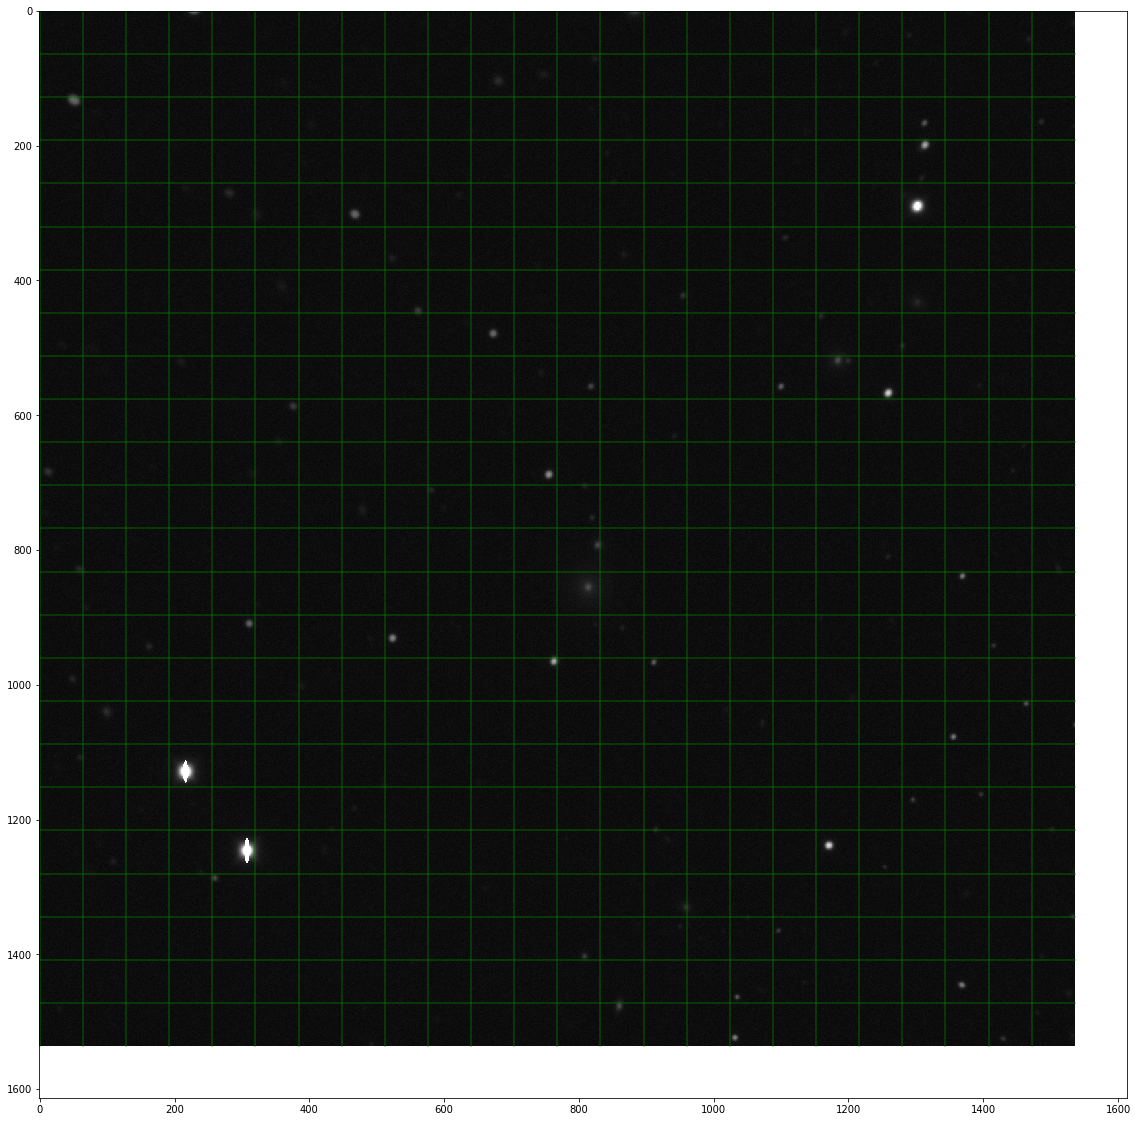

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(img, cmap='Greys_r', norm=SymLogNorm(10))
for i in range(img.shape[0]//cell_size):
    plt.plot([i*cell_size, i*cell_size], [0, img.shape[1]], c='g', alpha=0.5)
for i in range(img.shape[1]//cell_size):
    plt.plot([0, img.shape[0]], [i*cell_size, i*cell_size], c='g', alpha=0.5)
plt.show()

In [8]:
def get_stats(data, kappa=2.):
    # Compute mean and standard deviation over the original data
    mean, std = np.mean(data), np.std(data)
    # Compute first cut, +- std * kappa
    lcut, hcut = mean - std * kappa, mean + std * kappa
    # Filter values using this cuts
    f = np.logical_and(data >= lcut, data <= hcut)
    return np.mean(data[f]), np.std(data[f]), np.sum(f)

In [9]:
wcells = img.shape[0]//cell_size
hcells = img.shape[1]//cell_size
bgmodel = np.zeros((wcells, hcells))
for x in range(wcells):
    for y in range(hcells):
        cell = img[x * cell_size:(x + 1) * cell_size, y * cell_size:(y+1) * cell_size].ravel()
        mean, std, npoints = get_stats(cell)
        hist = BackgroundHistogram(mean, std, npoints)
        hist.add(cell)
        v, s = hist.get_backguess()
        bgmodel[x, y] = v

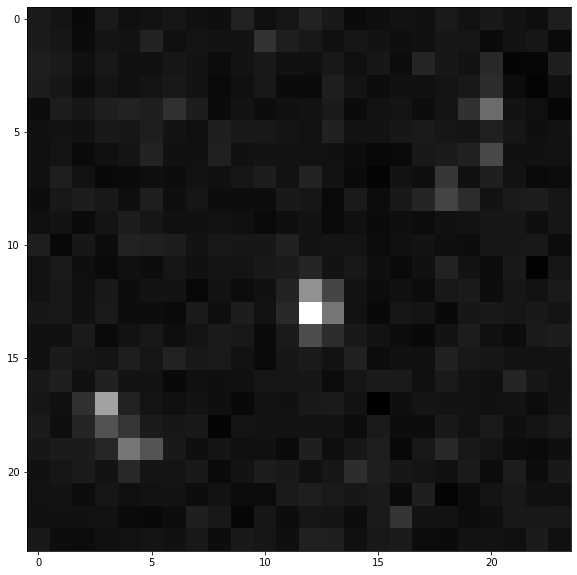

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(bgmodel, cmap='Greys_r', norm=SymLogNorm(1000))
plt.show()

# Median filtering

In [30]:
def clip(p, w, size):
    if w > p:
        return p
    if w > size - p - 1:
        return size - p - 1
    return w

def get_box(img, i, j, size):
    w = clip(i, size//2, img.shape[0])
    h = clip(j, size//2, img.shape[1])
    return img[i-w:i+w+1,j-h:j+h+1]

def median_filter(img, box_size = 3):
    filtered = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            box = get_box(img, i, j, box_size)
            filtered[i, j] = np.median(box)
    return filtered

In [31]:
get_box(bgmodel, 0, 0, 3)

array([[817.36893447]])

In [32]:
filtered = median_filter(bgmodel)

# Compare

In [33]:
sx = fits.open('/home/aalvarez/Work/Data/sim11/histo.fits')[0].data

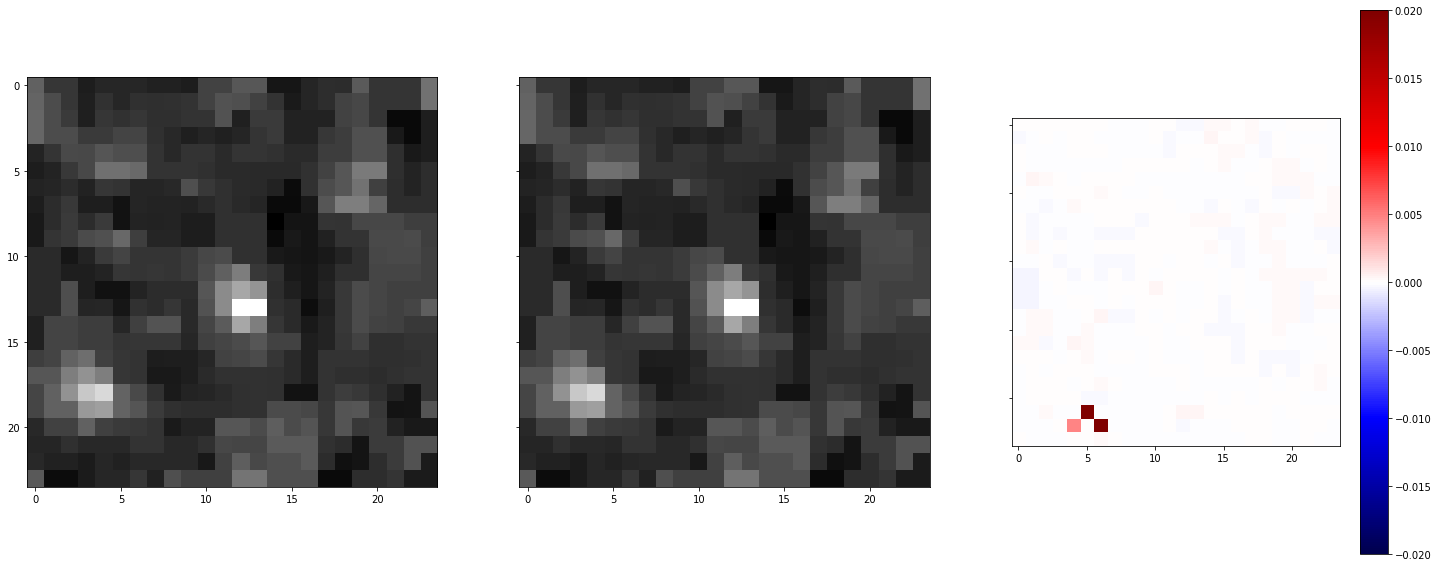

In [36]:
norm = SymLogNorm(100)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(25,10), sharex=True, sharey=True)
axes[0].imshow(sx, cmap='Greys_r', norm=norm)
axes[1].imshow(filtered, cmap='Greys_r', norm=norm)
d = axes[2].imshow(sx - filtered, cmap='seismic', norm=Normalize(-0.02, 0.02))
plt.colorbar(d)
plt.show()

# Save

In [16]:
fits.PrimaryHDU(bgmodel).writeto('bgmodel.fits', overwrite=True)